<a href="https://colab.research.google.com/github/Erhtric/NeuralQuestionGenerationNLP/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Miscellanous

This is the main file: its purpouse is to collect all the code coming from the coding pipeline.

In [1]:
#!pip install -U tensorflow-addons
#!pip install -q "tensorflow-text==2.8.*"
# !pip install keras-nlp

In [2]:
import pandas as pd
import numpy as np
import json
import sklearn
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import re
import os
import typing
from typing import Any, Tuple, List, NamedTuple
import spacy
import gensim
import gensim.downloader as gloader
from gensim.models import KeyedVectors
#import seaborn as sns
from itertools import chain
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
#import tensorflow_addons as tfa
#import tensorflow_text as tf_text
from tensorflow import keras
from keras.layers import (
    Layer, 
    Embedding, 
    LSTM, 
    Dense, 
    Bidirectional, 
    Input, 
    AdditiveAttention,
    Dropout)

# import keras_nlp
import nltk
#from nltk import punkt, pos_tag, ne_chunk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use this variable if you want to switch between the custom and builtin implementations.

In [37]:
use_builtins = True

This class is used to check shapes.

In [38]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

Commands to prepare the folder to accomodate data.

In [4]:
%cd /content/drive/MyDrive/NLP/Project/Testing folder/Eric
%pwd

# disable chained assignments to avoid annoying warning
pd.options.mode.chained_assignment = None 

/content/drive/.shortcut-targets-by-id/1cVw6eUwM-dRL9BhqtXULyOqeXDrYkwmH/NLP/Project/Testing folder/Eric


In [5]:
if not os.path.exists('./data'):
  print('Data folder does not exists. Creating it')
  os.makedirs('./data')

if not os.path.exists('./training_checkpoints'):
  print('Training checkpoint folder does not exists. Creating it')
  os.makedirs('./training_checkpoints')

In [6]:
print({tf.__version__})

{'2.8.2'}


This is for the `configuration.json` file, or something similar: 

In [7]:
batch_size = 16
units = 600

dataset_config = {
    # 'num_examples': 18896,
    'num_examples': 1500,
    'num_words_context': 45000,
    'num_words_question': 28000,
    'buffer_size': 32000,
    'batch_size': batch_size,
    'random_seed': 13,
}

encoder_config = {
    'context_vocab_size': None,
    'embedding_dimension': 300,
    'units': units,
    'batch_size': batch_size,
    'max_length_context': None
}

decoder_config = {
    'question_vocab_size': None,
    'embedding_dimension': 300,
    'units': units,
    'batch_size': batch_size,
    'max_length_question': None,
}

trainer_config = {
    'epochs': 15,
    'optimizer': tf.optimizers.Nadam(learning_rate=1.),
    # 'optimizer': tf.optimizers.SGD(learning_rate=1.),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(), 
}

path = {
    'training_json_path': "./data/training_set.json",
    'save_pkl_path': "./data/squadv2.pkl",
    'checkpoint_dir': "./training_checkpoints",
}


# 1. Data handling and Pre-processing


Things to do:
1. Add to each sentence $x$ a start of sequence `<SOS>` tag and end of sequence `<EOS>` tag,
2. Clean the sentences by removing special chars,
3. Perform other preprocessing steps,
4. Create a **vocabulary** with a word-to-index and index-to-word mappings by using a **tokenizer**, 
5. Extract the sentences that contain an answer and use them as input features, whereas the question will be our target
6. Pad each context to maximum length.

The resulting data that will be used hereinafter will be of type `tf.data.Dataset`. 

In [8]:
class Dataset(NamedTuple):
  """
  This class represent a a 3-way split processed dataset. 
  """
  # Reference :- https://github.com/topper-123/Articles/blob/master/New-interesting-data-types-in-Python3.rst
  train: tf.data.Dataset
  val: tf.data.Dataset
  test: tf.data.Dataset

class SQuAD:
  def __init__(self):
    self.random_seed = None
    self.squad_df = None
    self.preproc_squad_df = None
    self.tokenizer = None
    self.buffer_size = 0
    self.batch_size = 0

  def __call__(self,
           num_examples, 
           buffer_size, 
           batch_size, 
           random_seed,
           training_json_path,
           save_pkl_path,
           num_words_context=None,
           num_words_question=None,
           tokenized=True,
           pos_ner_tag=True,
           tensor_type=True):
    """The call() method loads the SQuAD dataset, preprocess it and optionally it returns 
    it tokenized. Moreover it also perform a 3-way split.

    Args:
        num_examples (int): number of examples to be taken from the original SQuAD dataset
        num_words (int): the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept. 
        buffer_size (int): buffer size for the shuffling operation
        batch_size (int): size of the batches
        tokenized (boolean): specifies if the context and question data should be both tokenized
        pos_ner_tag (boolean):
        tensro_type (boolean): 

    Returns (depending on the input parameters):
        pd.DataFrame: training dataset
        pd.DataFrame: validation dataset
        pd.DataFrame: testing dataset
          OR
        NamedTuple: dataset, (dict, dict, dict)
    """
    self.random_seed = random_seed
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.training_json_path = training_json_path
    self.save_pkl_path = save_pkl_path
    self.pos_ner_tag = pos_ner_tag
    self.max_length_context = 0
    self.max_length_question = 0

    # Load dataset from file
    self.load_dataset(num_examples)
    # Extract answer
    self.extract_answer()
    # Preprocess context and question
    self.preprocess()
    
    # Perform splitting
    X_train, y_train, X_val, y_val, X_test, y_test = self.split_train_val(self.preproc_squad_df)
    
    if self.pos_ner_tag: 
      pass

    # Initialize Tokenizer for the source: in our case the context phrases
    # alternatively TextVectorization 
    self.tokenizer_context = tf.keras.preprocessing.text.Tokenizer(filters='', 
                                                                   oov_token='<unk>',
                                                                   num_words=num_words_context)
    # initialize also for the target, namely the question phrases
    self.tokenizer_question = tf.keras.preprocessing.text.Tokenizer(filters='', 
                                                                   oov_token='<unk>',
                                                                   num_words=num_words_question)

    if tokenized:
      X_train_tokenized, word_to_idx_train_context = self.__tokenize_context(X_train)
      y_train_tokenized, word_to_idx_train_question = self.__tokenize_question(y_train)

      # update the max length for the other splits
      self.max_length_context = X_train_tokenized.context.iloc[0].shape[0]
      self.max_length_question = y_train_tokenized.iloc[0].shape[0]

      X_val_tokenized, word_to_idx_val_context = self.__tokenize_context(X_val)
      y_val_tokenized, word_to_idx_val_question = self.__tokenize_question(y_val)

      X_test_tokenized, word_to_idx_test_context = self.__tokenize_context(X_test)
      y_test_tokenized, word_to_idx_test_question = self.__tokenize_question(y_test)

      word_to_idx_context = (word_to_idx_train_context, word_to_idx_val_context, word_to_idx_test_context)
      word_to_idx_question = (word_to_idx_train_question, word_to_idx_val_question, word_to_idx_test_question)
      
      if tensor_type:
        AUTOTUNE = tf.data.AUTOTUNE

        # Returns tf.Data.Dataset objects (tokenized)
        train_dataset = self.to_tensor(X_train_tokenized, y_train_tokenized)
        val_dataset = self.to_tensor(X_val_tokenized, y_val_tokenized)
        test_dataset = self.to_tensor(X_test_tokenized, y_test_tokenized)

        # Configure the dataset for performance
        train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
        val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
        test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

        dataset = Dataset(
            train=train_dataset, 
            val=val_dataset,
            test=test_dataset)

        return dataset, word_to_idx_context, word_to_idx_question
      else:
        # Returns pd.DataFrame objects (tokenized)
        return X_train_tokenized, y_train_tokenized, X_val_tokenized, y_val_tokenized, X_test_tokenized, y_test_tokenized
    else:
      return X_train, y_train, X_val, y_val, X_test, y_test

  def load_dataset(self, num_examples):
    """
    Extract the dataset from the json file. Already grouped by title.

    :param path: [Optional] specifies the local path where the training_set.json file is located

    :return
        - the extracted dataset in a dataframe format
    """
    if os.path.exists(self.save_pkl_path):
      print('File already exists! Loading from .pkl...\n')
      self.squad_df = pd.read_pickle(self.save_pkl_path)
      self.squad_df = self.squad_df[:num_examples]
    else:
      print('Loading from .json...\n')
      with open(self.training_json_path) as f:
          data = json.load(f)

      df_array = []
      for current_subject in data['data']:
          title = current_subject['title']

          for current_context in current_subject['paragraphs']:
              context = current_context['context']

              for current_question in current_context['qas']:
                  question = current_question['question']
                  id = current_question['id']

              for answer_text in current_question['answers']:
                    answer = answer_text['text']
                    answer_start = answer_text['answer_start']
                    record = { "id": id,
                                "title": title,
                                "context": context,
                                "question": question,
                                "answer_start": answer_start,
                                "answer": answer
                                }

              df_array.append(record)
      
      # Save file
      pd.to_pickle(pd.DataFrame(df_array), self.save_pkl_path)
      self.squad_df = pd.DataFrame(df_array)[:num_examples]

  def preprocess(self):
    df = self.squad_df.copy()

    # Pre-processing context
    context = list(df.context)
    preproc_context = []

    for c in context:
      c = self.__preprocess_sentence(c, question=False)
      preproc_context.append(c)
    
    df.context = preproc_context

    # Pre-processing questions
    question = list(df.question)
    preproc_question = []

    for q in question:
      q = self.__preprocess_sentence(q, question=True)
      preproc_question.append(q)
    
    df.question = preproc_question

    # Remove features that are not useful
    df = df.drop(['id'], axis=1)
    self.preproc_squad_df = df

  def __preprocess_sentence(self, sen, question):
    # Creating a space between a word and the punctuation following it
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sen = re.sub(r"([?.!,¿])", r" \1 ", sen)
    sen = re.sub(r'[" "]+', " ", sen)

    # Replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sen = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", sen)

    sen = sen.strip()

    # Adding a start and an end token to the sentence so that the model know when to 
    # start and stop predicting.
    # if not question: sen = '<SOS> ' + sen + ' <EOS>'
    sen = '<SOS> ' + sen + ' <EOS>'
    return sen

  def __answer_start_end(self, df):
    """
    Creates a list of starting indexes and ending indexes for the answers.

    :param df: the target Dataframe

    :return: a dataframe containing the start and the end indexes foreach answer (ending index is excluded).

    """
    start_idx = df.answer_start
    end_idx = [start + len(list(answer)) for start, answer in zip(list(start_idx), list(df.answer))]
    return pd.DataFrame(list(zip(start_idx, end_idx)), columns=['start', 'end'])

  def split_train_val(self, df, train_size=0.8):
    """
    This method splits the dataframe in training and test sets, or eventually, in training, validation and test sets.

    Args
        :param df: the target Dataframe
        :param random_seed: random seed used in the splits
        :param train_size: represents the absolute number of train samples
        :param val: boolean for choosing between a 3-way split or 2-way one.

    Returns:
        - Data and labels for training, validation and test sets if val is True 
        - Data and labels for training and test sets if val is False 

    """
    # Maybe we have also to return the index for the starting answer
    X = df.drop(['answer_start', 'question', 'answer'], axis=1).copy()
    idx = self.__answer_start_end(df)
    X['start'] = idx['start']
    X['end'] = idx['end']
    y = df['question']

    # In the first step we will split the data in training and remaining dataset
    splitter = GroupShuffleSplit(train_size=train_size, n_splits=2, random_state=self.random_seed)
    split = splitter.split(X, groups=X['title'])
    train_idx, rem_idx = next(split)

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_rem = X.iloc[rem_idx]
    y_rem = y.iloc[rem_idx]


    # Val and test test accounts for 10% of the total data. Both 5%.
    splitter = GroupShuffleSplit(train_size=train_size, n_splits=2, random_state=self.random_seed)
    split = splitter.split(X_rem, groups=X_rem['title'])
    val_idx, test_idx = next(split)

    X_val = X_rem.iloc[val_idx]
    y_val = y_rem.iloc[val_idx]

    X_test = X_rem.iloc[test_idx]
    y_test = y_rem.iloc[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test

  def __tokenize_context(self, X):
    context = X.context
    self.tokenizer_context.fit_on_texts(context)
    context_tf = self.tokenizer_context.texts_to_sequences(context)

    # context_lengths = [len(seq) for seq in context_tf]
    # sns.boxplot(context_lengths)

    if self.max_length_context != 0:
      context_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(context_tf, maxlen=self.max_length_context, padding='post')
    else:
      context_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(context_tf, padding='post')


    for i, _ in enumerate(context):
      X['context'].iloc[i] = context_tf_pad[i]

    # Add the padding
    self.tokenizer_context.word_index['<pad>'] = 0
    self.tokenizer_context.index_word[0] = '<pad>'

    return X, self.tokenizer_context.word_index

  def __tokenize_question(self, y):
    question = y
    self.tokenizer_question.fit_on_texts(question)
    question_tf = self.tokenizer_question.texts_to_sequences(question)

    # question_lengths = [len(seq) for seq in question_tf]
    # sns.boxplot(question_lengths)
    
    if self.max_length_question != 0:
      question_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(question_tf, maxlen=self.max_length_question, padding='post')
    else:
      question_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(question_tf, padding='post')

    for i, _ in enumerate(question):
      y.iloc[i] = question_tf_pad[i]

    # Add the padding
    self.tokenizer_question.word_index['<pad>'] = 0
    self.tokenizer_question.index_word[0] = '<pad>'

    return y, self.tokenizer_question.word_index

  def extract_answer(self):
    df = self.squad_df.copy()
    start_end = self.__answer_start_end(df)
    context = list(df.context)
    
    selected_sentences = []
    for i, par in enumerate(context):
      sentences = sent_tokenize(par)
      start = start_end.iloc[i].start
      end = start_end.iloc[i].end      
      right_sentence = ""
      context_characters = 0

      for j, sen in enumerate(sentences):
        sen += ' '
        context_characters += len(sen)
        # If the answer is completely in the current sentence
        if(start < context_characters and end <= context_characters):
          right_sentence = sen
          selected_sentences.append(right_sentence)
          break
        # the answer is in both the current and the next sentence
        if(start < context_characters and end > context_characters):
          right_sentence = sen + sentences[j+1]
          selected_sentences.append(right_sentence)
          break 

    self.squad_df.context = selected_sentences

  def to_tensor(self, X, y, train=True):
    X = X.context.copy()
    y = y.copy()

    # Reference:- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(list(X), tf.int64), 
         tf.cast(list(y), tf.int64)))
    if train: 
      dataset = dataset.shuffle(self.buffer_size).batch(self.batch_size, drop_remainder=True)
    else:
      dataset = dataset.batch(self.batch_size, drop_remainder=True)

    return dataset

By calling the `SQuAD` constructor we create a dataset handling object which will be useful for future operations.

In [9]:
dataset_creator = SQuAD()

## 1.1 Preprocessed untokenized split

In [10]:
# Preprocessed dataset without tokenizing
# %%time
# X_train, y_train, X_val, y_val, X_test, y_test = dataset_creator.call(num_examples=dataset_creator.og_n_samples+1,
#                                                                       num_words=None,
#                                                                       BUFFER_SIZE=32000,
#                                                                       BATCH_SIZE=64,
#                                                                       random_seed=RANDOM_SEED,
#                                                                       tokenized=False)

# print(f'Set target: {X_train.columns.values}')

# print(f'Train set samples: {X_train.shape[0]}')
# print(f'Validation set samples: {X_val.shape[0]}')
# print(f'Test set samples: {X_test.shape[0]}')

# %%time
# X_train, y_train, X_val, y_val, X_test, y_test = dataset_creator(**dataset_config, **path, tokenized=False)

## 1.2 Tokenized split

### 1.2.1 Tensor Ready

This is the data produced that we are most interested in. As we can see we will have:
- a data structure `dataset` containing the training, validation and test set;
- a tuple containing the word-to-token mappings for the training, validation and test set respectively.

In [11]:
# Preprocessed dataset without tokenizing
%%time
dataset, word_to_idx_context, word_to_idx_question = dataset_creator(**dataset_config, 
                                                                     training_json_path=path['training_json_path'], 
                                                                     save_pkl_path=path['save_pkl_path'], 
                                                                     tokenized=True)

max_length_context = dataset.train.element_spec[0].shape[1]
max_length_question = dataset.train.element_spec[1].shape[1]

print(f'Sentences max lenght: {max_length_context}')
print(f'Questions max lenght: {max_length_question}')

File already exists! Loading from .pkl...

Sentences max lenght: 122
Questions max lenght: 27
CPU times: user 1.65 s, sys: 140 ms, total: 1.79 s
Wall time: 2.44 s


Accessing such `NamedTuple` data structure (cfr `dataset`) is pretty simple, namely in a:
1. tuple-way by accessing it like a list, e.g. `train = dataset[0]`,
2. object-way by calling the instance parameters, e.g. `train = dataset.train`.

The other two returned values are the word to index mappings for the context and question words respectively. In order to refer to a specific split simply call:
1. for the training dataset,
2. for the validation dataset,
3. for the test dataset,

In [12]:
print(f'Training vocab size for the context: {len(word_to_idx_context[0])}')
print(f'Training vocab size for the question: {len(word_to_idx_question[0])}')
print()
print(f'Validation vocab size for the context: {len(word_to_idx_context[1])}')
print(f'Validation vocab size for the question: {len(word_to_idx_question[1])}')
print()
print(f'Test vocab size for the context: {len(word_to_idx_context[2])}')
print(f'Test vocab size for the question: {len(word_to_idx_question[2])}')

Training vocab size for the context: 7120
Training vocab size for the question: 3132

Validation vocab size for the context: 8707
Validation vocab size for the question: 3775

Test vocab size for the context: 8894
Test vocab size for the question: 3848


### 1.2.2 Standard

In [13]:
# Preprocessed dataset without tokenizing
# %%time
# X_train, y_train, X_val, y_val, X_test, y_test = dataset_creator.call(num_examples=dataset_creator.og_n_samples+1,
#                      BUFFER_SIZE=32000,
#                      BATCH_SIZE=64,
#                      random_seed=RANDOM_SEED,
#                      tokenized=True,
#                      tensor_type=False)

# print(f'\nSet target: {X_train.columns.values}')

# print(f'Train set samples: {X_train.shape[0]}')
# print(f'Validation set samples: {X_val.shape[0]}')
# print(f'Test set samples: {X_test.shape[0]}')

## 1.3 Original SQuAD dataset

In [14]:
# Original dataset
# squad_df = dataset_creator.squad_df
# print(f'[Info] SQuAD target: {list(squad_df.columns.values)}')
# print(f'[Info] Shape: {squad_df.shape}')

# 2. GloVe and embedding matrix

In [20]:
class GloVe:
  def __init__(self, embedding_dimension):
    self.embedding_dimension = embedding_dimension

    try:
      self.embedding_model = KeyedVectors.load(f'./data/glove_model_{self.embedding_dimension}')
    except FileNotFoundError:
      print('[Warning] Model not found in local folder, please wait...')
      self.embedding_model = self.load_glove()
      self.embedding_model.save(f'./data/glove_model_{self.embedding_dimension}')  
      print('Download finished. Model loaded!')

  def load_glove(self):
    """
    Loads a pre-trained GloVe embedding model via gensim library.

    We have a matrix that associate words to a vector of a user-defined dimension.
    """

    download_path = "glove-wiki-gigaword-{}".format(self.embedding_dimension)

    try:
      emb_model = gloader.load(download_path)
    except ValueError as e:
      print("Generic error when loading GloVe")
      print("Check embedding dimension")
      raise e

    emb_model = gloader.load(download_path)
    return emb_model

  def build_embedding_matrix(self, word_to_idx, vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the 
        dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, self.embedding_dimension), dtype=np.float32)
    oov_count = 0
    oov_words = []

    # For each word which is not present in the vocabulary we assign a random vector, otherwise we take the GloVe embedding
    for word, idx in tqdm(word_to_idx.items()):
      try:
        embedding_vector = self.embedding_model[word]
      except (KeyError, TypeError):
        oov_count += 1
        oov_words.append(word)
        embedding_vector = np.random.uniform(low=-0.5, 
                                             high=0.5, 
                                             size=self.embedding_dimension)

      embedding_matrix[idx] = embedding_vector
    
    print(f'\n[Debug] {oov_count} OOV words found!\n')
    return embedding_matrix, oov_words

The next step is to initialize the handler with the desidered `embedding_dimension`. Then to build the embedding matrix with the pre-trained GloVe embeddings simply call the `build_embedding_matrix` method.

In [21]:
%%time
# Initalize the handler for GloVe
glove_handler = GloVe(encoder_config['embedding_dimension'])

# We will create the matrix by using only the words present in the training and validation set
embedding_matrix_context, oov_words_context = glove_handler.build_embedding_matrix(
    word_to_idx_context[1], 
    len(word_to_idx_context[1])+1)

embedding_matrix_question, oov_words_question = glove_handler.build_embedding_matrix(
    word_to_idx_question[1], 
    len(word_to_idx_question[1])+1)

100%|██████████| 8707/8707 [00:00<00:00, 120682.34it/s]



[Debug] 284 OOV words found!



100%|██████████| 3775/3775 [00:00<00:00, 124526.13it/s]


[Debug] 103 OOV words found!

CPU times: user 1.42 s, sys: 283 ms, total: 1.7 s
Wall time: 2.46 s


Convert both of them into tensor, but it is fine to also treat them as `numpy` array, still it is better to use the `tensorflow` fundamentals.

In [17]:
embedding_matrix_context = tf.convert_to_tensor(embedding_matrix_context)
embedding_matrix_question = tf.convert_to_tensor(embedding_matrix_question)

# 3. Model Definition

In [22]:
example_context_batch, example_question_batch = next(iter(dataset.val))

## 3.1 Encoder
We will use a bidirectional LSTM to encode the sentence,
$$
\begin{align*}
\overrightarrow{b_t} &= \overrightarrow{\text{LSTM}}(x_t, \overrightarrow{b_{t-1}})\\
\overleftarrow{b_t} &= \overleftarrow{\text{LSTM}}(x_t, \overleftarrow{b_{t+1}})\\
\end{align*}
$$
where $\overrightarrow{b_t}$ is the hidden state at time step $t$ for the forward pass LSTM and $\overleftarrow{b_t}$ for the backward pass.

In [249]:
class Encoder(tf.keras.Model):
  def __init__(self, 
               context_vocab_size, 
               embedding_matrix,
               embedding_dimension, 
               units, 
               batch_size, 
               max_length_context,
               **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.batch_size = batch_size
    self.max_length_context = max_length_context

    # Input node
    self.input_layer = Input(shape=(self.max_length_context,), 
                             batch_size = batch_size, 
                             dtype=tf.int32)
    
    self.embedding = Embedding(input_dim=context_vocab_size+1,
                               output_dim=embedding_dimension,
                               input_length=max_length_context,
                               embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                               trainable=False,
                               mask_zero=True,
                               name='encoder_embedding_layer') 
    
    self.bi_lstm = Bidirectional(LSTM(units//2, return_sequences=True, return_state=True), 
                                  name='encoder_bi_lstm',
                                  merge_mode='concat')

    # self.dropout = Dropout(.3)

    self.concatenate = tf.keras.layers.Concatenate(axis=1) 

    self.output_layer = self.call(self.input_layer)

  def call(self, inputs, state=None, training=True):
    # 1. The input is a tokenized and padded sentence containing the answer from the context
    
    # 2. The embedding layer looks up for the embedding for each token
    vectors = self.embedding(inputs)

    # 3. The Bi-LSTM processes the embedding sequence forward and backward:
    #     output shape: ('batch', 'max_length_context', 'units')
    #     hidden state shape: fw ('batch', 'units//2'), bw ('batch', 'units//2')
    #     cell state shape: fw ('batch', 'units//2'), bw ('batch', 'units//2')
    output, forward_h, forward_c, backward_h, backward_c = self.bi_lstm(vectors, initial_state=state, training=training)

    # 4. Concatenate the forward and the backward states
    h = self.concatenate([forward_h, backward_h])
    c = self.concatenate([forward_c, backward_c])
    encoder_state = [h, c]

    # 5. Return the new sequence processed by the encoder and its state
    return output, encoder_state

  # Reference :- https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
  def build_model(self):
    x = Input(shape=(self.max_length_context,), batch_size=self.batch_size)
    return tf.keras.Model(inputs=x, outputs=self.call(x))
  
  def plot_model(self):
    return tf.keras.utils.plot_model(
        self.build_model(), 
        # to_file='encoder.png', dpi=96,              
        show_shapes=True, show_layer_names=True,  
        expand_nested=True                       
    )

```
output = self.dropout_layer(output, training=training)

# encoder_outputs shape = (batch_size, max_length_context, units)
# forward_h shape = (batch_size, units//2)
# forward_c shape = (batch_size, units//2)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = self.bidirectional_lstm(output, initial_state=(forward_h, forward_c, backward_h, backward_c), training=training)
```

### 3.1.1 Test the encoder stack



In [250]:
encoder_config['context_vocab_size'] = len(word_to_idx_context[1])
encoder_config['max_length_context'] = dataset.train.element_spec[0].shape[1]

encoder = Encoder(**encoder_config, embedding_matrix=embedding_matrix_context)
encoder_outputs, encoder_state = encoder(inputs=example_context_batch)

hidden_state, cell_state = encoder_state

print(f'Decoder output shape: (batch_size, max_length_context, units): {encoder_outputs.shape}')
print(f'Hidden state shape: (batch_size, units): {hidden_state.shape}')
print(f'Cell state shape: (batch_size, units): {cell_state.shape}')

(16, 300)
(16, 300)
Decoder output shape: (batch_size, max_length_context, units): (16, 122, 600)
Hidden state shape: (batch_size, units): (16, 600)
Cell state shape: (batch_size, units): (16, 600)


In [251]:
encoder.summary()

Model: "encoder_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_embedding_layer (Em  (16, 122, 300)           2612400   
 bedding)                                                        
                                                                 
 encoder_bi_lstm (Bidirectio  [(16, 122, 600),         1442400   
 nal)                         (16, 300),                         
                              (16, 300),                         
                              (16, 300),                         
                              (16, 300)]                         
                                                                 
 concatenate_24 (Concatenate  (16, 600)                0         
 )                                                               
                                                                 
Total params: 4,054,800
Trainable params: 1,442,400
Non-

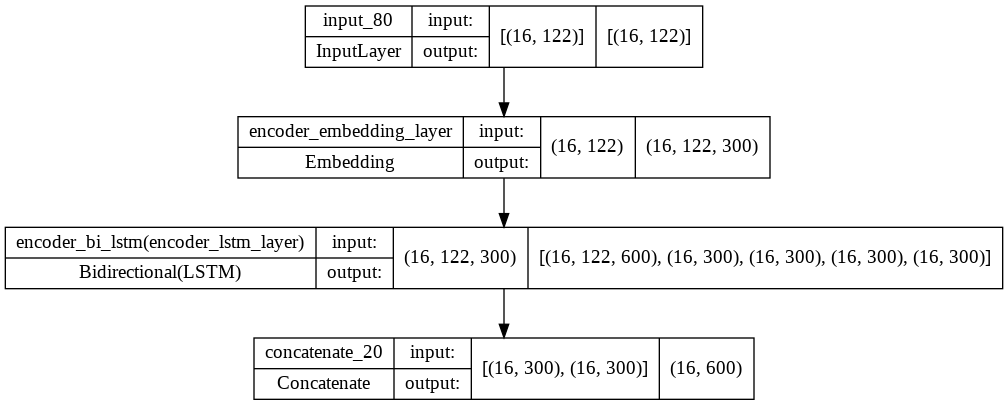

In [237]:
encoder.plot_model()

## 3.2 Attention Head

In [ ]:
class BahdanauAttention(Layer):
  # Still it is possible to use Luang's attention as an alternative
  # Reference:- https://www.tensorflow.org/text/tutorials/nmt_with_attention
  def __init__(self, units):
    super().__init__()
    self.W1 = Dense(units, use_bias=False, name='Wb1_attention_weights')
    self.W2 = Dense(units, use_bias=False, name='Wb2_attention_weights')

    self.attention = AdditiveAttention(use_scale=True)

  def call(self, query, value, mask):
    """
    This layer takes 3 inputs:
      - the query; this will be generated by the decoder, later,
      - the value: the output of the encoder,
      - the mask: to exclude the padding, i.e., context_batch != 0.
    """
    #W1@ht
    w1_query = self.W1(query)
    #W2@hs
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask = [query_mask, value_mask],
        return_attention_scores = True,
    )
    
    return context_vector, attention_weights

This layer takes 3 inputs:
- the `query`: this will be generated by the decoder, later.
- the `value`: this will be the output of the encoder.
- the `mask`: to exclude the padding.

The attention results will be of shape:
1. *context vector* shape: `(batch, query_seq_length, units)`,
2. *attention weights* shape: `(batch, query_seq_length, value_seq_length)`. They should sum to `1.0` for each sequence `t`.

## 3.3 Decoder

In [253]:
# Container classes
# Reference :- https://www.tensorflow.org/text/tutorials/nmt_with_attention
class DecoderInput(NamedTuple):
  new_token: Any
  enc_output: Any
  mask: Any

class DecoderOutput(NamedTuple):
  logits: Any
  attention_weights: Any

In [256]:
class Decoder(tf.keras.Model):
  def __init__(self, 
               question_vocab_size, 
               embedding_matrix, 
               embedding_dimension,
               units, 
               batch_size, 
               max_length_question,
               **kwargs):
    
    super(Decoder, self).__init__(**kwargs)
    self.batch_size = tf.constant(batch_size)
    self.max_length_question = tf.constant(max_length_question)
    self.embedding_dimension = tf.constant(embedding_dimension)
    self.units = tf.constant(units)

    # Layers definition
    self.input_layer = Input(shape=(None,), batch_size=self.batch_size)
                        
    # Embedding for the questions
    self.embedding = Embedding(input_dim=question_vocab_size+1,
                               output_dim=embedding_dimension,
                              #  input_length=self.max_length_question,
                               embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                               trainable=False,  #?
                               mask_zero=True,
                               name='decoder_embedding_layer')
    
    # The LSTM layer
    self.lstm_layer = LSTM(units//2,
                          return_sequences=True,
                          return_state=True,
                          name='decoder_lstm_layer')
    
    # The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(units//2)

    # self.Wt = Dense(units, activation=tf.math.tanh, use_bias=False, name='decoder_Wt_weights')
    self.Wt = Dense(units, activation=tf.nn.relu, use_bias=False, name='decoder_Wt_weights')

    # For the word probabilities
    self.Ws = Dense(question_vocab_size, activation=tf.nn.softmax, use_bias=False, name='decoder_Ws_weights')

    # self.dropout_layer = Dropout(.3)

    # self.call(self.input_layer)

  def call(self, 
           inputs: DecoderInput, 
           state=None,
           training=True) -> Tuple[DecoderOutput, Tuple[tf.Tensor]]:

    # Lookup the embeddings for the questions
    x = self.embedding(inputs.new_token)
    # embedded_tensor shape: (batch_size, 1, embedding_dimension)
    if tf.shape(x).shape == 2: x = tf.expand_dims(x, axis=1)

    # Process one step with the RNN
    # LSTM expects inputs of shape: (batch_size, timestep, feature)
    cell_output, hidden_dec_state, cell_dec_state = self.lstm_layer(x, initial_state=state, training=training)

    cell_output = self.dropout_layer(cell_output, training=training)

    cell_output, hidden_dec_state, cell_dec_state = self.lstm_layer(cell_output, initial_state=(hidden_dec_state, cell_dec_state), training=training)
    
    # Use the LSTM cell output as the query for the attention over the encoder output.
    context_vector, attention_weights = self.attention(
        query=cell_output, 
        value=inputs.enc_output, 
        mask=inputs.mask)

    # Join the context_vector and cell output [ct; ht] shape: (batch t, value_units + query_units)
    cell_output_and_context_vector = tf.concat([cell_output, context_vector], axis=-1)

    # at = tanh(Wt@[ht, ct])
    attention_vector = self.Wt(cell_output_and_context_vector, training=training)

    # logits = softmax(Ws@at)
    logits = self.Ws(attention_vector, training=training)

    return DecoderOutput(logits, attention_weights), (hidden_dec_state, cell_dec_state)

### 3.3.1 Test the decoder stack

The decoder will take as input:
1. `new_tokens`: the last token generated of shape `(batch_size, 1)`, namely the token obrained in the previous time step of the decoder (we will initialize the decoder with the `"<sos>"` token);
2. `enc_output`: this is the representation produced by the `Encoder` of shape `(batch_size, max_length_context, enc_units)`;
3. `mask`: this is the mask, that is a boolean tensor, indicating which tokens will be considered in the decoding of shape `(batch_size, max_length_context)`; 
4. `decoder_state`: the previous state of the decoder, namely the internal state of the decoder's LSTM (the paper suggests to input the hidden and cell state produced by the Bi-LSTM). The shape is `[(batch_size, enc_units), (batch_size, enc_units)]`.



In [257]:
decoder_config['question_vocab_size'] = len(word_to_idx_question[1])
decoder_config['max_length_question'] = dataset.train.element_spec[1].shape[1]

decoder = Decoder(**decoder_config, embedding_matrix=embedding_matrix_question)

AttributeError: ignored

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
start_tag_index = word_to_idx_question[2]['<sos>']
first_token = tf.squeeze(tf.constant([[start_tag_index]] * decoder_config['batch_size']), axis=1)

In [ ]:
decoder_result, decoder_state = decoder(
    inputs = DecoderInput(first_token, 
                          encoder_outputs,
                          mask=(example_context_batch != 0)),
    state = encoder_state
)

hidden_dec_state, cell_dec_state = decoder_state

print(f'Logits shape: (batch_size, t, output_vocab_size) {decoder_result.logits.shape}')
print(f'Hidden state shape: (batch_size, dec_units) {hidden_dec_state.shape}')
print(f'Cell state shape: (batch_size, dec_units) {cell_dec_state.shape}')

Logits shape: (batch_size, t, output_vocab_size) (16, 1, 3775)
Hidden state shape: (batch_size, dec_units) (16, 300)
Cell state shape: (batch_size, dec_units) (16, 300)


In this case we cannot provide a detailed summary or a handy plot due to the fact that we pass to the decoder model a structured input which is not preferred by tensorflow.

In [ ]:
decoder.summary()

Model: "decoder_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_embedding_layer (Em  multiple                 1132800   
 bedding)                                                        
                                                                 
 decoder_lstm_layer (LSTM)   multiple                  721200    
                                                                 
 bahdanau_attention_39 (Bahd  multiple                 180300    
 anauAttention)                                                  
                                                                 
 decoder_Wt_weights (Dense)  multiple                  360000    
                                                                 
 decoder_Ws_weights (Dense)  multiple                  2265000   
                                                                 
 dropout_79 (Dropout)        multiple                  0

Moving on: this means that the decoder will produce a vector of probabilities associated to each vocabulary word. That is, a vector of logits $l_b \in \mathbb{R}^{\mathcal{V}}$ for each element $b$ in the batch, namely indicating the next probable token for a given sentence. Since they are logits they should sum up to `1.0`, evenutally a number really close to it. 

In [ ]:
decoder_result.logits[0, 0, :].numpy().sum(axis=0)

0.99999994

Now we sample a token according to the logits computed by the decoder.

In [ ]:
sampled_tokens = tf.random.categorical(
    logits=decoder_result.logits[:, 0, :],
    num_samples=1, 
    seed=dataset_config['random_seed'])
vocab = np.array(list(word_to_idx_question[1].keys()))

first_word = list(vocab[tf.squeeze(sampled_tokens, axis=-1).numpy()])
first_word[:5]

['roofs', 'burn', '1942', 'dropout', 'buechner']

In [ ]:
decoder_result, _ = decoder(
    inputs = DecoderInput(sampled_tokens, 
                          encoder_outputs,
                          mask=(example_context_batch != 0)),
    state = decoder_state
)

sampled_tokens = tf.random.categorical(
    logits=decoder_result.logits[:, 0, :], 
 
    num_samples=1, 
    seed=dataset_config['random_seed'])
sampled_tokens = tf.squeeze(sampled_tokens, axis=-1).numpy()

first_word = list(vocab[sampled_tokens])
first_word[:5]

['heart', 'brother', 'wolves', 'speakers', 'musician']

# 4. Training for QG

## 4.1 Training checkpoints

See [Manual Checkpointing](https://www.tensorflow.org/guide/checkpoint).

In [ ]:
checkpoint_prefix = os.path.join(path['checkpoint_dir'], "tf_ckpt")
optimizer = tf.keras.optimizers.Adam()
train_iterator = iter(dataset.train) 
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

manager = tf.train.CheckpointManager(checkpoint,
                                     checkpoint_prefix,
                                     max_to_keep=3)

## 4.2 Loss

The **QG** task is defined as finding $\hat{y}$ such that:
$$
\hat{y} = \arg{\max_y P(y|x)}  
$$
where $P(y|x)$ is the conditional log-likelihood of the predicted question sentence $y$ given the input $x$. Du et al. shown that the conditional probability could be factorized in:
$$
P(y|x) = \prod_{t=1}^{|y|} P(y_t|x, y_{<t})
$$
where the probability of each $y_t$ is predicted based on all the words that have been generated upon time $t$, namely $y_{<t}$.

This means that given a training corpus of sentence-question pairs $\mathcal{S} = \{(x^{(i)}, y^{(i)})\}_{i=1}^N$, the objective is to minimize the negative log-likelihood:
$$
\begin{align*}
\mathcal{L} &= - \sum_{i=1}^N \log P(y^{(i)}|x^{(i)}; \theta)\\
            &=  - \sum_{i=1}^N \sum_{j=1}^{|y^{(i)}|} \log P (y_j^{(i)}|x^{(i)}, y_{<j}^{(i)}; \theta)
\end{align*}
$$
We parameterize the probability of decoding each word $y_j$ by using an RNN:
$$
P(y_j|y_{<j}, s) = \text{softmax}(g(h_j))
$$
where $g(.)$ is a transition function that outputs a vocabulary-sized vector.

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'conditional_ll_loss'

    # The loss needs to work with logits since the decoder is outputting the most probable token
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction='none'
    )

  def __call__(self, y_true, y_pred):
    # Calculate the loss for each item in the batch
    # Shape of y_true = (batch_size, )
    # Shape of y_pred = (batch_size, 1, vocab_size)
    loss = self.loss(y_true=y_true, y_pred=y_pred)
    
    # Mask of the losses on the padding
    mask = tf.math.not_equal(y_true, 0)
    loss = tf.boolean_mask(loss, mask)
    loss = tf.reduce_sum(loss)

    # Return the total
    return loss

In [ ]:
l = MaskedLoss()

l([1., 2., 0., 0.], [[0.3, 0.6, 0.1], [0.1, 0.1, 0.8], [0.3, 0.6, 0.1], [0.3, 0.6, 0.1]])

<tf.Tensor: shape=(), dtype=float32, numpy=1.5430132>

In [ ]:
m = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
m([1, 2], [[0.3, 0.6, 0.1], [0.1, 0.1, 0.8]])

<tf.Tensor: shape=(), dtype=float32, numpy=0.7715066>

## 4.3 Metrics

The metrics used during training will be:
1. perplexity,
2. masked accuracy,
3. masked f1 score.

They will be implemented by exploiting the `Metric` object in `tensorflow`. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric) for more.

In [ ]:
class Perplexity(tf.keras.metrics.Metric):
  def __init__(self, name='perplexity', **kwargs):
    super(Perplexity, self).__init__(name=name, **kwargs)
    self.scores = self.add_weight(name='perplexity_scores', initializer='zeros')

  def update_state(self, loss):
    """
    Reference :- https://www.surgehq.ai/blog/how-good-is-your-chatbot-an-introduction-to-perplexity-in-nlp
    """
    self.scores.assign(tf.exp(loss))

  def result(self): return self.scores
  def reset_state(self): self.scores.assign(0)

# Also the accuracy should mask the padding
class MaskedAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name='masked_accuracy',**kwargs):
    super(MaskedAccuracy, self).__init__(name=name, **kwargs)
    self.scores = self.add_weight(name='accuracy_scores', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    # We mask since we are not interested in the final accuracy score
    mask = tf.cast(tf.math.greater(y_true, 0), dtype=tf.float32)

    correct = tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32)
    correct = tf.math.reduce_sum(mask * correct)
    total_legit = tf.math.reduce_sum(mask)

    self.scores.assign(correct / total_legit)

  def result(self): return self.scores
  def reset_state(self): self.scores.assign(0)

## 4.3 QG model and training step implementation

The training step should:
1. Run the encoder on the `input_tokens` to get the `encoder_outputs`, `hidden_state` and `cell_state`. 

In [ ]:
class QGeneratorTrainer(tf.keras.Model):
  def __init__(self,
               context_vocab_size,
               question_vocab_size,
               embedding_dimension,
               embedding_matrix_context,
               embedding_matrix_question,
               units,
               batch_size,
               max_length_context,
               max_length_question,
               use_tf_function=True,
               **kwargs):
    """
    Prepare the model for the training. It builds the both the encoder and the decoder.
    Also it defines a wrapper to use the tf.function compilation for the tensorflow computational
    graph.
    """
    super().__init__(**kwargs)
    self.encoder = Encoder(
        context_vocab_size,
        embedding_matrix_context,
        embedding_dimension,
        units,
        batch_size,
        max_length_context)

    self.decoder = Decoder(
        question_vocab_size,
        embedding_matrix_question,
        embedding_dimension,
        units, 
        batch_size,
        max_length_question)

    self.max_length_question = max_length_question
    self.batch_size = batch_size
    self.use_tf_function = use_tf_function

    self.perplexity_metric = Perplexity()
    self.accuracy_metric = MaskedAccuracy()

    self.loss_tracker = []

  def call(self, inputs, training=True, masks=None):
    """
    It performs a forward pass. Calls the model on new inputs and returns the outputs as tensors.
    """
    context = inputs[0]
    question = inputs[1]

    context_mask = self.__get_mask(context)
    question_mask = self.__get_mask(question)

    # Encode the input
    encoder_output, encoder_state = self.encoder(context, training=True)

    # The decoder should be initialized with the encoder last state 
    decoder_state = encoder_state 

    # We collect the question predicted by the decoder, the first character is the starting token
    pred_question = tf.fill([self.batch_size, 1], question[0][0])
    
    # Keep a loss tracking value
    loss = tf.constant(0.0)
    t = 0

    # Reference :- https://www.tensorflow.org/guide/function
    # We have to run the decoder for all the length of the question 
    while t < (self.max_length_question - 1):
      # We have to pass two tokens:
      #   1. the token at time step t, namely the token in which we need to start run the decoder 
      #   2. the token at time step t+1, that is the next token in the sequence that needs to be compared with
      new_token = tf.gather(question, t, axis=1)
      target_token = tf.gather(question, t+1, axis=1)

      # Here we call the decoder in order to produce the token at time step t+1, it returns,
      #   1. the partial loss for the predicted token,
      #   2. the new decoder state,
      #   3. the predicted token at time step t+1
      step_loss, decoder_state, pred_token = self.step_decoder(
          (new_token, target_token),
          context_mask,
          encoder_output,
          decoder_state, 
          training=True)

      pred_question = tf.concat([pred_question, pred_token], axis=1)

      loss = loss + step_loss
      t = t + 1

    return pred_question, loss

  @tf.function
  def step_decoder(self, 
                   tokens,
                   context_mask,
                   encoder_output,
                   decoder_state,
                   training):
    """
    Run a single iteration of the decoder and computers the incremental loss between the
    produced token and the token in the target input.
    """
    new_token, target_token = tokens
    
    # Run the decoder one time
    decoder_result, decoder_state = self.decoder(
        inputs = DecoderInput(
            new_token=new_token,
            enc_output=encoder_output,
            mask=context_mask),
        state = decoder_state, 
        training = training)
  
    y_true = target_token
    y_pred = decoder_result.logits

    step_loss = self.loss(y_true=y_true, y_pred=y_pred)
    y_pred = tf.cast(tf.math.argmax(y_pred, axis=-1), dtype=tf.int64)
    return step_loss, decoder_state, y_pred

  def train_step(self, inputs):
    """
    Wrapper that switches on and off the tf.function compilation for performance, see the 
    tensorflow documentation for the computation graph.
    """
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

  @tf.function
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

  @property
  def metrics(self):
    # We list our `Metric` objects here so that `reset_states()` can be called 
    # automatically at the start of each epoch or at the start of `evaluate()`.
    # If you don't implement this property, you have to call # `reset_states()` 
    # yourself at the time of your choosing.
    return [self.perplexity_metric, self.accuracy_metric]

  def _train_step(self, inputs):
    """
    Optimization step for a batch.
    """
    context, question = inputs

    with tf.GradientTape() as tape:
      pred_question, loss = self(inputs, training=True)

      # Average the loss for all the legit tokens
      # avg_loss = loss / tf.math.reduce_sum(tf.cast(self.__get_mask(question), dtype=loss.dtype))

      avg_loss = tf.math.divide_no_nan(loss, tf.math.reduce_sum(tf.cast(self.__get_mask(question), dtype=loss.dtype)))
      self.loss_tracker.append(avg_loss)

    # Compute gradients
    tr_variables = self.trainable_variables
    grads = tape.gradient(avg_loss, tr_variables)

    print(grads[-1])

    # Apply some clipping (by norm) as done in the paper and update the weights
    # grads = [tf.clip_by_norm(g, 5.0) for g in grads]
    # grads = [tf.math.pow(g, 20) for g in grads]
    self.optimizer.apply_gradients(zip(grads, tr_variables))

    # Compute metrics
    self.perplexity_metric.update_state(avg_loss)
    self.accuracy_metric.update_state(question, pred_question)

    return {'batch_loss': avg_loss, 'perplexity': self.perplexity_metric.result(), 'accuracy': self.accuracy_metric.result()}
    
  def __get_mask(self, tokens):
    """
    Generate a boolean mask for those elements which are not <pad>.
    """ 
    return tf.math.not_equal(tokens, 0)

In [ ]:
train_model = QGeneratorTrainer(**encoder_config,
                             question_vocab_size=decoder_config['question_vocab_size'],
                             max_length_question=decoder_config['max_length_question'],
                             embedding_matrix_context=embedding_matrix_context,
                             embedding_matrix_question=embedding_matrix_question,
                             use_tf_function=False)

# We do not pass any metric here since they are already in the model 
# Reference :- https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
train_model.compile(
    # optimizer=trainer_config['optimizer'],
    # optimizer=tf.optimizers.Nadam(learning_rate=1e-1),
    optimizer=tf.optimizers.Adam(1e-2),
    loss=MaskedLoss(),
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

### 4.3.2 Simple Training
The first call with `use_tf_function=True` will be slow since it has to trace the function. So be patient or try `use_tf_function=False` 😀

In [ ]:
batch = next(iter(dataset.train))
train_model.train_step(batch)

tf.Tensor(
[[1.7051702e-10 1.7698865e-10 1.7252089e-10 ... 1.7614971e-10
  1.7301530e-10 1.8996119e-10]
 [2.5049873e-10 2.6200739e-10 2.5536145e-10 ... 2.6152228e-10
  2.5569730e-10 2.7961564e-10]
 [2.2679152e-09 2.2759465e-09 2.2801012e-09 ... 2.3023361e-09
  2.2469493e-09 2.4400153e-09]
 ...
 [5.1782560e-09 5.1681095e-09 5.1957585e-09 ... 5.2302909e-09
  5.1220548e-09 5.5237153e-09]
 [4.4586388e-09 4.4680588e-09 4.4902424e-09 ... 4.5103983e-09
  4.4276565e-09 4.7882289e-09]
 [1.5917836e-09 1.6144189e-09 1.6145698e-09 ... 1.6311239e-09
  1.6032559e-09 1.7386131e-09]], shape=(600, 3775), dtype=float32)


{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.06837607>,
 'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.672999>,
 'perplexity': <tf.Tensor: shape=(), dtype=float32, numpy=2149.5178>}

In [ ]:
# %%time
# losses = []
# for n in tqdm(range(10)):
#   # print('.', end='')
#   logs = qg_model.train_step(next(iter(dataset.train)))
#   losses.append(logs['batch_loss'].numpy())

# print()
# plt.plot(losses)
# print()
# print(losses)

## 4.4 Tensorboard

## 4.5 Train the model

First we define some useful callbacks.

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key) -> None:
    self.key = key
    self.logs = []

  def on_train_batch_ends(self, n, logs):
    self.logs.append(logs[self.key])

def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  elif epoch == 8:
    return lr / 2
  else: 
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Loss as tf.Variable? 
Instead of using masking we compute it also on padding

In [ ]:
batch_loss = BatchLogs('batch_loss')
perplexity = BatchLogs('perplexity')
accuracy = BatchLogs('accuracy')
history = train_model.fit(
    dataset.train, 
    batch_size=dataset_config['batch_size'],
    # epochs=trainer_config['epochs'],
    epochs=15, 
    callbacks=[batch_loss, perplexity, accuracy, lr_scheduler],
    # validation_data=dataset.val, 
    # validation_batch_size=dataset_config['batch_size'],
    verbose='auto',
    use_multiprocessing = True,
    )

Epoch 1/15
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Tensor("AddN_17:0", shape=(600, 3775), dtype=float32)
69/69 [==============================] - 58s 678ms/step - batch_loss: 7.6052 - perplexity: 2043.6941 - accuracy: 0.1157 - lr: 0.0100
Epoch 2/15
69/69 [==============================] - 48s 692ms/step - batch_loss: 7.6035 - perplexity: 2043.6941 - accuracy: 0.1124 - lr: 0.0100
Epoch 3/15
69/69 [==============================] - 47s 676ms/step - batch_loss: 7.6035 - perplexity: 2043.6941 - accuracy: 0.1124 - lr: 0.0100


KeyboardInterrupt: ignored

In [ ]:
for i, var in enumerate(train_model.trainable_variables):
    print(train_model.trainable_variables[i].name)

#5. Evaluation for QG


In [ ]:
class QGeneratorEvaluator(tf.Module):
  def __init__(self):
    pass

  def test_step(self, inputs):
    context, question = inputs

    # Generate teh mask for both the context and the question
    context_mask = self.__get_mask(context)
    question_mask = self.__get_mask(question)

    encoder_output, encoder_state = self.encoder(context, training=False)
    decoder_state = encoder_state
    loss = tf.constant(0.0)
    t = 0

    # Reference :- https://www.tensorflow.org/guide/function
    # We have to run the decoder for all the length of the question 
    while t < (self.max_length_question - 1):
      # We have to pass two tokens:
      #   1. the token at time step t, namely the token in which we need to start run the decoder 
      #   2. the token at time step t+1, that is the next token in the sequence that needs to be compared with
      new_token = tf.gather(question, t, axis=1)
      target_token = tf.gather(question, t+1, axis=1)

      step_loss, metric_value, decoder_state = self.step_decoder(
          (new_token, target_token),
          context_mask,
          encoder_output,
          decoder_state, 
          training=True)

      loss = loss + step_loss
      # self.custom_metric_mean.update_state(metric_value)
      t = t + 1

    # Average the loss for all the legit tokens
    avg_loss = loss / tf.math.reduce_sum(tf.cast(question_mask, dtype=loss.dtype))
    # return {f'batch_loss': avg_loss, f'batch_perplexity': self.custom_metric_mean.result()}
    return {f'batch_loss': avg_loss}

# 6. Inference for QG
In this section we will provide the class and the methods for the inference part. More specifically, both auxiliary and inferencing methods:
1. `token_to_string()`:
2. `string_to_token()`:
3. `create_mask()`:
4. `temperature_sampling()`:
5. `generate_question()`:

In [ ]:
class QGeneratorInference(tf.Module):
  def __init__(self, encoder, decoder, tokenizer, word_to_idx, use_tf_function):
    self.encoder = encoder
    self.decoder = decoder
    self.tokenizer = tokenizer
    self.word_to_idx = word_to_idx
   
    self.result_tokens = None
    self.result_text = None
    self.token_mask = self.create_mask()

    self.start_idx = word_to_idx['<sos>']
    self.end_idx = word_to_idx['<eos>']
    self.use_tf_function = False

  def token_to_string(self, result_tokens: tf.Tensor):  
    """
    This method converts token IDs to text by using a given mapping.
    """
    list_tokens = result_tokens.numpy().tolist()
    list_text = self.tokenizer.sequences_to_texts(list_tokens)
    list_text = tf.convert_to_tensor([list_text])
    result_text = tf.strings.reduce_join(list_text, axis=0, separator=' ')
    result_text = tf.strings.strip(result_text)
    
    self.result_tokens = result_tokens
    self.result_text = result_text
    return result_text

  def string_to_token(self, result_str: tf.Tensor):
    """
    This method converts texts to token IDs by using a given mapping.
    """  
    list_str = [s.decode("utf-8") for s in result_str.numpy().tolist()]
    list_tokens = self.tokenizer.texts_to_sequences(list_str)
    list_tokens = tf.convert_to_tensor(list_tokens, dtype=tf.int64)
    result_tokens = tf.squeeze(tf.split(list_tokens, num_or_size_splits=list_tokens.shape[0], axis=0), axis=1)

    return result_tokens
  
  def create_mask(self):
    """
    This method creates a mask for the padding, the unknwon words and the start/ending tokens.
    """
    masked_words = ['<pad>', '<unk>', '<sos>', '<eos>']
    token_mask_ids = [self.tokenizer.word_index[mask] for mask in masked_words]

    token_mask = np.zeros(shape=(len(self.word_to_idx),), dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    return token_mask

  # evaluate or predict?
  def evaluate(self, inputs, max_length, return_attention, mode='greedy', temperature=0.5):
    """
    Wrapper that switches on and off the tf.function compilation for performance, see the 
    tensorflow documentation for the computation graph.
    """
    if mode == 'greedy':
      if self.use_tf_function:
        return self._tf_generate_greedy(inputs, max_length, temperature, return_attention)
      else:
        return self._generate_greedy(inputs, max_length, temperature, return_attention)
    elif mode == 'beam':
      return self._generate_beam(inputs, max_length, return_attention)

  @tf.function
  def _tf_generate_greedy(self, inputs, max_length, temperature, return_attention):
    return self._generate_question_greedy(inputs, max_length, return_attention, temperature)
  
  def _generate_greedy(self, 
                        inputs,
                        max_length,
                        return_attention,
                        temperature):
    batch_size = tf.shape(inputs)[0]

    # Similarly for what it has been done in the train step
    encoder_output, encoder_state = self.encoder(inputs)
    decoder_state = encoder_state

    # Generate the first token of each sentence, that is the <sos> token
    new_token = tf.fill([batch_size, 1], self.start_idx)

    result_tokens = []
    attention = []
    timestep = 0
    
    while timestep < max_length:
      # Decode the token at the next timestep
      decoder_result, decoder_state = self.decoder(
        inputs = DecoderInput(
            new_token=new_token,
            enc_output=encoder_output,
            mask=(inputs != 0)),
        state = decoder_state)
      
      attention.append(decoder_result.attention_weights)

      # Sample the new token accordingly to the distribution produced by the decoder
      new_token = self.temperature_sampling(decoder_result.logits, temperature)

      # if a sequence has reached <eos> set it as done
      # MISSING PART

      result_tokens.append(new_token)

      timestep = timestep + 1
    
    # MISSING
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.token_to_string(result_tokens)

    attention_stack = tf.concat(attention, axis=-1)

    # HANDLING UNK WORDS

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

  def temperature_sampling(self, logits, temperature):
    """

    For the temperature choice see here:
      Reference :- https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/
    """
    # First of all we use broadcast the generated mask to the expected logits' shape
    # token_mask shape: (batch_size, timestep, vocab_size)
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # The logits for all the tokens that have to not be used are set top -1.0
    logits = tf.where(token_mask, -1.0, logits)

    # Freezing function
    # Higher temperature -> greater variety
    # Lower temperature -> grammatically correct
    if temperature == 0.0:
      # the freezing function is the argmax, behaving like a greedy search
      new_token = tf.argmax(logits, axis=-1)
    else:
      # the freezing function now scales the logits.
      # for temperature == 1.0 is the identity function
      logits = tf.squeeze(logits, axis=1)
      new_token = tf.random.categorical(logits / temperature, num_samples=1)
    return new_token

  # def _beam_search(self, k, max_length, encoder_output, encoder_state, mask):
  #   decoder_states = list()
    
  #   for i in range(k):
  #     decoder_states.append(encoder_state)

  #   print(decoder_states[0])
  #   # decoders = []
    
  #   sequences = [[list(), 0.0, 0]]
  #   timestep = 0
  #   new_tokens = tf.fill([1, k, 1], self.start_idx)
  #   all_candidates = list()
    
  #   while timestep < max_length:
  #     timestep = timestep+1
      
  #     for i in range(len(sequences)):
  #       seq, score, _ = sequences[i]

  #       decoder_result, decoder_state = self.decoder(
  #         inputs = DecoderInput(
  #             new_token=new_tokens[i],
  #             enc_output=encoder_output,
  #             mask=mask),
  #         state = decoder_states[i])

  #       decoder_states[i] = decoder_state
        
  #       for j in range(decoder.logits.shape[-1]):
  #         candidate = [seq + [j], score - np.log(decoder.logits[0][j]), i]
  #         all_candidates.append(candidate)
  #       # order all candidates by score
  #     ordered = sorted(all_candidates, key=lambda tup:tup[1])
  #     sequences = ordered[:k]
  #     new_tokens = list()
  #     # new_decoders = []
  #     new_decoder_states = []
  #     for k in range(k):
  #       new_tokens.append(all_candidates[k][0][-1])
  #       # new_decoders.append(decoders[all_candidates[k][2]])
  #       new_decoder_states.append(decoder_states[all_candidates[k][2]])
  #     # decoders = new_decoders
  #     decoder_states = new_decoder_states
  #   return sequences

  # def _generate_question_beam_search(self, inputs, max_length, return_attention=True):
  #   batch_size = tf.shape(inputs)[0]
  #   encoder_output, encoder_state = self.encoder(inputs)

  #   hidden_state, cell_state = encoder_state
  #   batch_sequences = []
  #   for i in range(batch_size):
  #     encoder_state_batch = (hidden_state[i, :], cell_state[i, :])
  #     sequences = self._beam_search(3, 
  #                                   max_length, 
  #                                   encoder_output[i, :, :], 
  #                                   encoder_state_batch, 
  #                                   (inputs[i,] != 0))
  #     batch_sequences.append(sequences)
  #   return batch_sequences


In [ ]:
qg_generator = QGeneratorInference(train_model.encoder, 
                                   train_model.decoder, 
                                   dataset_creator.tokenizer_question, 
                                   word_to_idx=word_to_idx_question[1], 
                                   use_tf_function=True)

In [ ]:
example_logits = tf.random.normal([5, 1, len(word_to_idx_question[1])])
example_output_tokens = qg_generator.temperature_sampling(example_logits, temperature=1.0)

In [ ]:
qg_generator.evaluate(example_output_tokens, max_length=10, return_attention=False, mode='greedy')